# DSCI_6004_02 NATURAL LANGUAGE PROCESSING
###            PROJECT BY
## AMANI KAMBHAM AND LAKSHMI SAI KISHORE SAVARAPU

### TITLE:EMOTION CLASSIFICATION OF TWEETS USING NATURAL LANGUAGE PROCESSING

Importing necessary Modules and Libraries

In [ ]:
import pandas as pd
from pprint import pprint
import warnings
warnings.filterwarnings('ignore')
import gc
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import resample
import string
import numpy as np
import tensorflow as tf
# import tensorflow_addons as tfa
#import keras_tuner as kt

Importing the Dataset

In [ ]:
data = pd.read_csv('tweet_emotions.csv')
data.head()

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


Exploratory Data Analysis

In [ ]:
len(data)

40000

In [ ]:
max_length = data['content'].str.len().max()

print('The maximum lenght tweet is: ', max_length)

The maximum lenght tweet is:  167


In [ ]:
data_count = data.sentiment.value_counts()
type(data_count)

pandas.core.series.Series

In [ ]:
data_count

sentiment
neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: count, dtype: int64

In [ ]:
total_unique_sentiments = data['sentiment'].nunique()

print("Total unique sentiment values: ",total_unique_sentiments)


Total unique sentiment values:  13


Splitting of Dataset

In [ ]:
m = data.shape[0]
train_split = 0.80 * m
val_split = (1 - 0.80) * m
test_split = 0.20 * val_split
val_split = (1 - 0.20) * val_split

print('Splitting ratio: ')
print()
print('train_split: ', train_split, ', val_split: ', val_split, ', test-split: ', test_split)

train_data = data.iloc[:int(train_split)]
val_data = data.iloc[int(train_split) + 1: int(train_split) + int(val_split)]
test_data = data.iloc[int(train_split) + int(val_split) + 1 : int(train_split) + int(val_split) + int(test_split)]
print()
print('All_Shapes: ')
print()
print(train_data.shape, val_data.shape, test_data.shape)

del val_split
del train_split
del test_split

Splitting ratio: 

train_split:  32000.0 , val_split:  6399.999999999999 , test-split:  1599.9999999999998

All_Shapes: 

(32000, 3) (6398, 3) (1598, 3)


In [ ]:
content_text = train_data.content.tolist()
all_classes = train_data.sentiment.unique().tolist()
content_text = train_data.content.tolist()
ex_char = string.punctuation
ex_char = ex_char.replace('~', '')
c_text = '~~~~~~'.join(content_text)

x = c_text.translate(str.maketrans('', '', ex_char))
c_text = x.split('~~~~~~')

#print('Samples: ',len(c_text))

token_data = tf.keras.preprocessing.text.Tokenizer(num_words=None,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',lower=True,split=' ')
token_data.fit_on_texts(c_text)
ind_text = token_data.texts_to_sequences(c_text)

print()

print('All_samples: ', len(ind_text))
word_index = token_data.word_index
print('Diff. words: ', len(list(word_index)))


All_samples:  32000
Diff. words:  45300


Text Cleaning and Pre-processing of Dataset

In [ ]:
label_token = tf.keras.preprocessing.text.Tokenizer(num_words=len(all_classes),
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',lower=True,split=' ')
classes = ' '.join(all_classes)
label_token.fit_on_texts([classes])
label_index = label_token.word_index
print('No. of Labels: ',len(list(label_index)))
print()
label_index = {key:value-1 for key, value in label_index.items()}
inv_label_index = {value:key for key, value in label_index.items()}
print()
print(inv_label_index)

No. of Labels:  13


{0: 'empty', 1: 'sadness', 2: 'enthusiasm', 3: 'neutral', 4: 'worry', 5: 'surprise', 6: 'love', 7: 'fun', 8: 'hate', 9: 'happiness', 10: 'boredom', 11: 'relief', 12: 'anger'}


In [ ]:
y_train = []
for i in train_data.sentiment:
    y_train.append(label_index.get(i))
y_train = np.array(y_train)
print('Label_shape: ', y_train.shape)
pprint(y_train[:10])

Label_shape:  (32000,)
array([0, 1, 1, 2, 3, 4, 1, 4, 1, 1])


In [ ]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(ind_text, padding='post')

max_inp_len = x_train.shape[1]
print('max_input_length: ', max_inp_len)


print('x_train_shape: ', x_train.shape, ', y_train_shape: ', y_train.shape)


max_input_length:  33
x_train_shape:  (32000, 33) , y_train_shape:  (32000,)


In [ ]:
import numpy as np
import tensorflow as tf
import string

def val_preprocess(val_data, token_data, label_index):
    content_text = val_data.content.tolist()
    ex_char = string.punctuation.replace('~', '')
    c_text = '~~~~~~'.join(content_text).translate(str.maketrans('', '', ex_char)).split('~~~~~~')

    print('Val_samples: ', len(c_text))

    # Tokenize and then pad sequences
    ind_text = token_data.texts_to_sequences(c_text)
    x_val = tf.keras.preprocessing.sequence.pad_sequences(ind_text, padding='post')

    print('All_Val_samples: ', len(ind_text))

    # Prepare labels
    y_val = np.array([label_index.get(i, -1) for i in val_data.sentiment])
    print('Label_shape: ', y_val.shape)

    return x_val, y_val


def test_preprocess(test_data, token_data, label_index):
    content_text = test_data.content.tolist()
    # Remove redundant line: all_classes = test_data.sentiment.unique().tolist()
    ex_char = string.punctuation.replace('~', '')  # Exclude '~' from being removed
    c_text = '~~~~~~'.join(content_text).translate(str.maketrans('', '', ex_char)).split('~~~~~~')

    print('Again_Test_samples: ', len(c_text))
    ind_text = token_data.texts_to_sequences(c_text)

    # Use pad_sequences here, no need to convert to numpy array manually after this
    x_test = tf.keras.preprocessing.sequence.pad_sequences(ind_text, padding='post')
    print('\nAll_Test_samples: ', len(ind_text))

    y_test = [label_index.get(i, -1) for i in test_data.sentiment]  # Use default value for missing labels
    y_test = np.array(y_test)
    print('Label_shape: ', y_test.shape)

    return x_test, y_test


print('Val_Preprocessing:')
x_val, y_val = val_preprocess(val_data, token_data, label_index)
#print(x_val.shape, y_val.shape)
print('--------')
print('Test_Preprocessing ...')
x_test, y_test = test_preprocess(test_data, token_data, label_index)
#print(x_test.shape, y_test.shape)

Val_Preprocessing:
Val_samples:  6398
All_Val_samples:  6398
Label_shape:  (6398,)
--------
Test_Preprocessing ...
Again_Test_samples:  1598

All_Test_samples:  1598
Label_shape:  (1598,)


In [ ]:
x_val = tf.keras.preprocessing.sequence.pad_sequences(x_val, maxlen = max_inp_len, padding = 'post')
print('x_val_shape: ',x_val.shape, ', y_val_shape: ', y_val.shape)
x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test, maxlen = max_inp_len, padding = 'post')
print('x_test_shape: ',x_test.shape, ', y_test_shape: ', y_test.shape)

x_val_shape:  (6398, 33) , y_val_shape:  (6398,)
x_test_shape:  (1598, 33) , y_test_shape:  (1598,)


Model Building and Evaluation

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# Model configuration
VOCABULARY_SIZE = 45300 + 1  # Adding 1 because index 0 is reserved
EMBEDDING_DIM = 100  # Dimensionality of the embedding vectors
LSTM_UNITS = 64  # Number of units in the LSTM layer
NUM_CLASSES = 13  # The number of sentiment labels

# Define the model
model = Sequential([
    Embedding(input_dim=VOCABULARY_SIZE, output_dim=EMBEDDING_DIM, input_length=33),
    LSTM(LSTM_UNITS),
    Dense(NUM_CLASSES, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 33, 100)           4530100   
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 13)                845       
                                                                 
Total params: 4573185 (17.45 MB)
Trainable params: 4573185 (17.45 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/25
1000/1000 [==============================] - 93s 91ms/step - loss: 2.0989 - accuracy: 0.2610 - val_loss: 2.1521 - val_accuracy: 0.2091
Epoch 2/25
1000/1000 [==============================] - 89s 89ms/step - loss: 1.8775 - accuracy: 0.3575 - val_loss: 2.0068 - val_accuracy: 0.3260
Epoch 3/25
1000/1000 [==============================] - 91s 91ms/step - loss: 1.5897 - accuracy: 0.4621 - val_loss: 2.1359 - val_accuracy: 0.3295
Epoch 4/25
1000/1000 [==============================] - 91s 91ms/step - loss: 1.3016 - accuracy: 0.5637 - val_loss: 2.3774 - val_accuracy: 0.3126
Epoch 5/25
1000/1000 [==============================] - 88s 88ms/step - loss: 1.0699 - accuracy: 0.6486 - val_loss: 2.6854 - val_accuracy: 0.2920
Epoch 6/25
1000/1000 [==============================] - 87s 87ms/step - loss: 0.8690 - accuracy: 0.7195 - val_loss: 2.8529 - val_accuracy: 0.2770
Epoch 7/25
1000/1000 [==============================] - 86s 86ms/step - loss: 0.7011 - accuracy: 0.7810 - val_loss: 3.1908 -

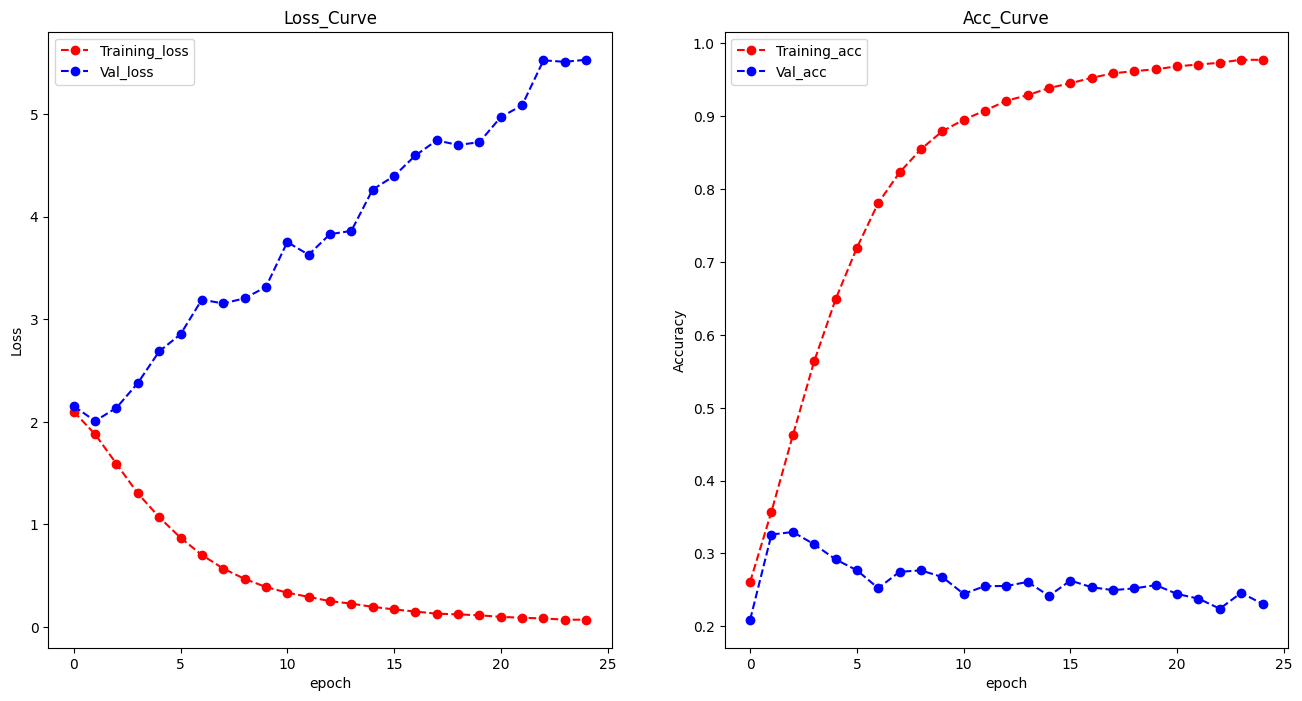

In [ ]:
hit = model.fit(x_train, y_train, epochs=25, validation_data=(x_val, y_val), batch_size=32)
print()
print('-- Evaluation --')
model.evaluate(x_test, y_test)
print()
hit_2 = hit.history

fig, axs = plt.subplots(1,2, figsize=(16,8))

axs[0].set_title('Loss_Curve')
ep = range(len(hit_2['loss']))
axs[0].plot(ep, hit_2['loss'],'o--r',label = 'Training_loss')
axs[0].plot(ep, hit_2['val_loss'],'o--b',label = 'Val_loss')
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].set_title('Acc_Curve')
ep = range(len(hit_2['loss']))
axs[1].plot(ep, hit_2['accuracy'],'o--r',label = 'Training_acc')
axs[1].plot(ep, hit_2['val_accuracy'],'o--b',label = 'Val_acc')
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, classification_report
import numpy as np

# Assuming ypred and y_test are already defined as per your previous code
ypred = model.predict(x_test)
ypred = np.argmax(ypred, axis=-1)

conf_matrix  = confusion_matrix(y_test, ypred)

print('--Confusion_Matrix--')
print(conf_matrix)
print()

print('f1_score: ', f1_score(y_test, ypred, average='micro'))
print('Precision: ', precision_score(y_test, ypred, average='micro'))
print('Recall: ', recall_score(y_test, ypred, average='micro'))

# Getting the classification report
print('--Classification Report--')
print(classification_report(y_test, ypred))


50/50 [==============================] - 1s 6ms/step
--Confusion_Matrix--
[[  3   4   1  10   2   0   1   0   0   3   0   2   0]
 [  0   8   3  11  11   4   4   1   1   7   0   2   0]
 [  1   3   2   9   9   1   4   4   0   5   0   1   0]
 [  9  30  14 128  57  24  31  14   2  40   0  21   0]
 [  5  22  11  43  45   9  12   4   2  19   0   7   0]
 [  2   7   2  18   7  10  10   6   1  17   0   5   0]
 [  5  13   6  39  15  13  77  12   2  83   0  12   0]
 [  1   7   4  18  13   4   9   5   1  26   1   1   0]
 [  0   3   0   8   8   1   0   0   1   1   1   0   0]
 [  6  18  12  58  44  21  45  39   0 104   0  15   1]
 [  0   0   1   2   1   1   0   0   0   0   0   0   0]
 [  3   8   7   9  16   8  12   5   0  13   0   7   0]
 [  0   0   0   1   0   0   0   0   0   0   0   0   0]]

f1_score:  0.24405506883604505
Precision:  0.24405506883604505
Recall:  0.24405506883604505
--Classification Report--
              precision    recall  f1-score   support

           0       0.09      0.12   

In [ ]:
import tensorflow as tf

input_sentence = "The movie is very good!"

sequence = token_data.texts_to_sequences([input_sentence])

padded_sequence = tf.keras.preprocessing.sequence.pad_sequences(sequence, maxlen=33, padding='post')

prediction = model.predict(padded_sequence)
predicted_class = tf.argmax(prediction, axis=1).numpy()

sentiment_label = inv_label_index[predicted_class[0]]

print(f"Predicted sentiment: {sentiment_label}")


1/1 [==============================] - 0s 20ms/step
Predicted sentiment: love


Importing Dataset

In [ ]:
data1 = pd.read_csv('tweet_emotions.csv')
data1.head()

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


Reversing of the Tweet Contents

In [ ]:
import pandas as pd

# Function to reverse the sentence
def reverse_sentence(sentence):
    return ' '.join(sentence.split()[::-1])

# Applying the function to the 'content' column and updating the same column with reversed sentences
data1['content'] = data1['content'].apply(reverse_sentence)

# The 'content' column now contains the reversed sentences
data1.head()

,tweet_id,sentiment,content
0,1956967341,empty,=[ part his at freakin started i and earlier h...
1,1956967666,sadness,call... your on ughhhh...waitin headache a wit...
2,1956967696,sadness,friday... ceremony...gloomy Funeral
3,1956967789,enthusiasm,SOON! friends with out hang to wants
4,1956968416,neutral,"will. one no but tickets, Houston has who some..."


Splitting of the Dataset

In [ ]:
m1 = data1.shape[0]
train_split_1 = 0.80 * m1
val_split_1 = (1 - 0.80) * m1
test_split_1 = 0.20 * val_split_1
val_split_1 = (1 - 0.20) * val_split_1

print('Splitting ratio: ')
print()
print('train_split: ', train_split_1, ', val_split: ', val_split_1, ', test-split: ', test_split_1)

train_data1 = data1.iloc[:int(train_split_1)]
val_data1 = data1.iloc[int(train_split_1) + 1: int(train_split_1) + int(val_split_1)]
test_data1 = data1.iloc[int(train_split_1) + int(val_split_1) + 1 : int(train_split_1) + int(val_split_1) + int(test_split_1)]
print()
print('All_Shapes: ')
print()
print(train_data1.shape, val_data1.shape, test_data1.shape)

del val_split_1
del train_split_1
del test_split_1

Splitting ratio: 

train_split:  32000.0 , val_split:  6399.999999999999 , test-split:  1599.9999999999998

All_Shapes: 

(32000, 3) (6398, 3) (1598, 3)


Text Cleaning and Pre-processing

In [ ]:
content_text1 = train_data1.content.tolist()
all_classes1 = train_data1.sentiment.unique().tolist()
content_text1 = train_data1.content.tolist()
ex_char1 = string.punctuation
ex_char1 = ex_char1.replace('~', '')
c_text1 = '~~~~~~'.join(content_text1)

x1 = c_text1.translate(str.maketrans('', '', ex_char1))
c_text1 = x1.split('~~~~~~')

#print('Samples: ',len(c_text))

token_data1 = tf.keras.preprocessing.text.Tokenizer(num_words=None,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',lower=True,split=' ')
token_data1.fit_on_texts(c_text1)
ind_text1 = token_data1.texts_to_sequences(c_text1)

print()

print('All_samples: ', len(ind_text1))
word_index1 = token_data1.word_index
print('Diff. words: ', len(list(word_index1)))


All_samples:  32000
Diff. words:  45303


In [ ]:
label_token1 = tf.keras.preprocessing.text.Tokenizer(num_words=len(all_classes1),
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',lower=True,split=' ')
classes1 = ' '.join(all_classes1)
label_token1.fit_on_texts([classes1])
label_index1 = label_token1.word_index
print('No. of Labels: ',len(list(label_index1)))
print()
label_index1 = {key:value-1 for key, value in label_index1.items()}
inv_label_index1 = {value:key for key, value in label_index1.items()}
print()
print(inv_label_index1)

No. of Labels:  13


{0: 'empty', 1: 'sadness', 2: 'enthusiasm', 3: 'neutral', 4: 'worry', 5: 'surprise', 6: 'love', 7: 'fun', 8: 'hate', 9: 'happiness', 10: 'boredom', 11: 'relief', 12: 'anger'}


In [ ]:
y_train1 = []
for i in train_data1.sentiment:
    y_train1.append(label_index1.get(i))
y_train1 = np.array(y_train1)
print('Label_shape: ', y_train1.shape)
pprint(y_train1[:10])

Label_shape:  (32000,)
array([0, 1, 1, 2, 3, 4, 1, 4, 1, 1])


In [ ]:
x_train1 = tf.keras.preprocessing.sequence.pad_sequences(ind_text1, padding='post')

max_inp_len1 = x_train1.shape[1]
print('max_input_length: ', max_inp_len1)


print('x_train_shape: ', x_train1.shape, ', y_train_shape: ', y_train1.shape)


max_input_length:  33
x_train_shape:  (32000, 33) , y_train_shape:  (32000,)


In [ ]:
import numpy as np
import tensorflow as tf
import string

def val_preprocess(val_data, token_data, label_index):
    content_text = val_data.content.tolist()
    ex_char = string.punctuation.replace('~', '')
    c_text = '~~~~~~'.join(content_text).translate(str.maketrans('', '', ex_char)).split('~~~~~~')

    print('Val_samples: ', len(c_text))

    # Tokenize and then pad sequences
    ind_text = token_data.texts_to_sequences(c_text)
    x_val = tf.keras.preprocessing.sequence.pad_sequences(ind_text, padding='post')

    print('All_Val_samples: ', len(ind_text))

    # Prepare labels
    y_val = np.array([label_index.get(i, -1) for i in val_data.sentiment])
    print('Label_shape: ', y_val.shape)

    return x_val, y_val


def test_preprocess(test_data, token_data, label_index):
    content_text = test_data.content.tolist()
    # Remove redundant line: all_classes = test_data.sentiment.unique().tolist()
    ex_char = string.punctuation.replace('~', '')  # Exclude '~' from being removed
    c_text = '~~~~~~'.join(content_text).translate(str.maketrans('', '', ex_char)).split('~~~~~~')

    print('Again_Test_samples: ', len(c_text))
    ind_text = token_data.texts_to_sequences(c_text)

    # Use pad_sequences here, no need to convert to numpy array manually after this
    x_test = tf.keras.preprocessing.sequence.pad_sequences(ind_text, padding='post')
    print('\nAll_Test_samples: ', len(ind_text))

    y_test = [label_index.get(i, -1) for i in test_data.sentiment]  # Use default value for missing labels
    y_test = np.array(y_test)
    print('Label_shape: ', y_test.shape)

    return x_test, y_test


print('Val_Preprocessing:')
x_val1, y_val1 = val_preprocess(val_data1, token_data1, label_index1)
#print(x_val1.shape, y_val1.shape)
print('--------')
print('Test_Preprocessing ...')
x_test1, y_test1 = test_preprocess(test_data1, token_data1, label_index1)
#print(x_test1.shape, y_test1.shape)

Val_Preprocessing:
Val_samples:  6398
All_Val_samples:  6398
Label_shape:  (6398,)
--------
Test_Preprocessing ...
Again_Test_samples:  1598

All_Test_samples:  1598
Label_shape:  (1598,)


In [ ]:
x_val1 = tf.keras.preprocessing.sequence.pad_sequences(x_val1, maxlen = max_inp_len1, padding = 'post')
print('x_val_shape: ',x_val1.shape, ', y_val_shape: ', y_val1.shape)
x_test1 = tf.keras.preprocessing.sequence.pad_sequences(x_test1, maxlen = max_inp_len1, padding = 'post')
print('x_test_shape: ',x_test1.shape, ', y_test_shape: ', y_test1.shape)

x_val_shape:  (6398, 33) , y_val_shape:  (6398,)
x_test_shape:  (1598, 33) , y_test_shape:  (1598,)


Model Building and Evaluation

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# Model configuration
VOCABULARY_SIZE = 45303 + 1  # Adding 1 because index 0 is reserved
EMBEDDING_DIM = 100  # Dimensionality of the embedding vectors
LSTM_UNITS = 64  # Number of units in the LSTM layer
NUM_CLASSES = 13  # The number of sentiment labels

# Define the model
model1 = Sequential([
    Embedding(input_dim=VOCABULARY_SIZE, output_dim=EMBEDDING_DIM, input_length=33),
    LSTM(LSTM_UNITS),
    Dense(NUM_CLASSES, activation='softmax')
])

# Compile the model
model1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model1.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 33, 100)           4530400   
                                                                 
 lstm_1 (LSTM)               (None, 64)                42240     
                                                                 
 dense_1 (Dense)             (None, 13)                845       
                                                                 
Total params: 4573485 (17.45 MB)
Trainable params: 4573485 (17.45 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/25
1000/1000 [==============================] - 78s 76ms/step - loss: 2.1131 - accuracy: 0.2408 - val_loss: 2.0857 - val_accuracy: 0.2396
Epoch 2/25
1000/1000 [==============================] - 74s 74ms/step - loss: 1.9165 - accuracy: 0.3294 - val_loss: 2.0110 - val_accuracy: 0.3392
Epoch 3/25
1000/1000 [==============================] - 78s 78ms/step - loss: 1.6315 - accuracy: 0.4448 - val_loss: 2.0947 - val_accuracy: 0.3274
Epoch 4/25
1000/1000 [==============================] - 76s 76ms/step - loss: 1.2892 - accuracy: 0.5790 - val_loss: 2.3390 - val_accuracy: 0.3132
Epoch 5/25
1000/1000 [==============================] - 76s 76ms/step - loss: 0.9858 - accuracy: 0.6852 - val_loss: 2.5468 - val_accuracy: 0.3007
Epoch 6/25
1000/1000 [==============================] - 76s 76ms/step - loss: 0.7483 - accuracy: 0.7627 - val_loss: 2.7591 - val_accuracy: 0.3024
Epoch 7/25
1000/1000 [==============================] - 73s 73ms/step - loss: 0.5862 - accuracy: 0.8137 - val_loss: 2.9284 -

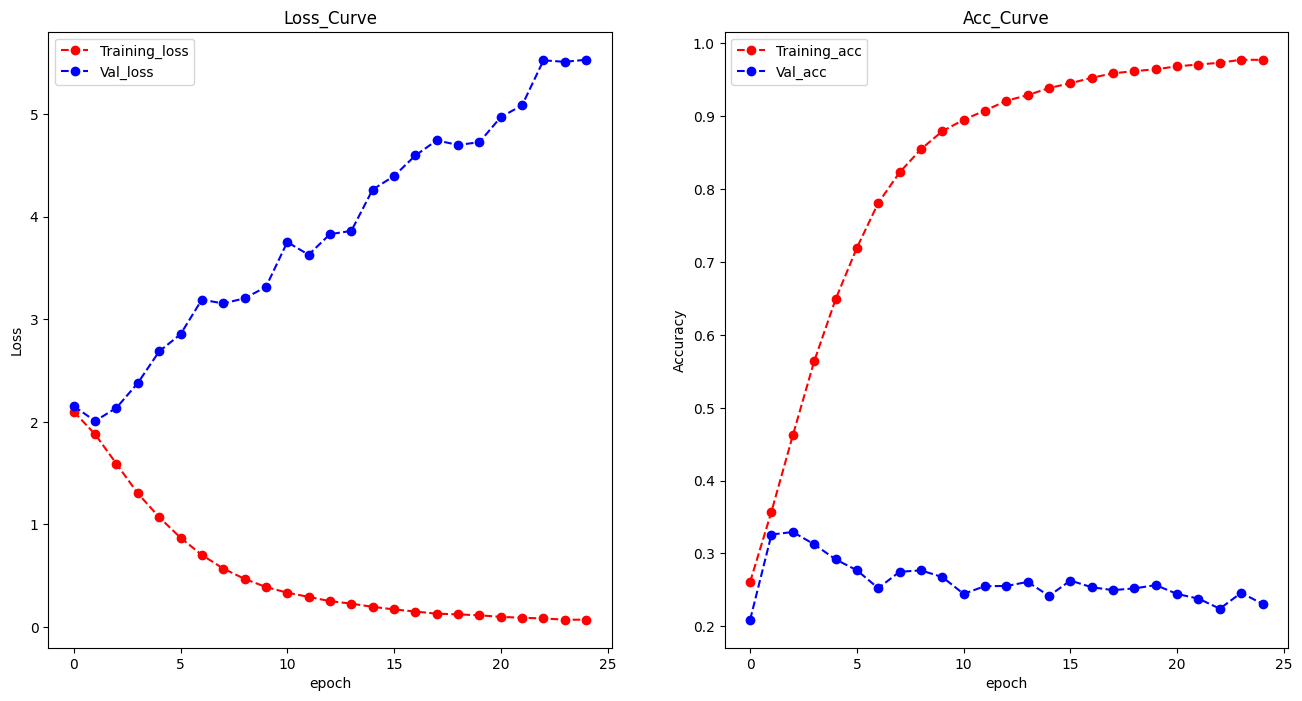

In [ ]:
hit1 = model1.fit(x_train1, y_train1, epochs=25, validation_data=(x_val1, y_val1), batch_size=32)
print()
print('-- Evaluation --')
model1.evaluate(x_test1, y_test1)
print()
hit_1 = hit1.history

fig, axs = plt.subplots(1,2, figsize=(16,8))

axs[0].set_title('Loss_Curve')
ep = range(len(hit_2['loss']))
axs[0].plot(ep, hit_2['loss'],'o--r',label = 'Training_loss')
axs[0].plot(ep, hit_2['val_loss'],'o--b',label = 'Val_loss')
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].set_title('Acc_Curve')
ep = range(len(hit_2['loss']))
axs[1].plot(ep, hit_2['accuracy'],'o--r',label = 'Training_acc')
axs[1].plot(ep, hit_2['val_accuracy'],'o--b',label = 'Val_acc')
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, classification_report
import numpy as np

# Assuming ypred and y_test are already defined as per your previous code
ypred1 = model1.predict(x_test1)
ypred1 = np.argmax(ypred1, axis=-1)

confuse_matrix  = confusion_matrix(y_test1, ypred1)

print('--Confusion_Matrix--')
print(confuse_matrix)
print()

print('f1_score: ', f1_score(y_test1, ypred1, average='micro'))
print('Precision: ', precision_score(y_test1, ypred1, average='micro'))
print('Recall: ', recall_score(y_test1, ypred1, average='micro'))

# Getting the classification report
print('--Classification Report--')
print(classification_report(y_test1, ypred1))

50/50 [==============================] - 1s 6ms/step
--Confusion_Matrix--
[[  0   1   0   8   6   4   2   0   0   3   0   2   0]
 [  0   8   1  13  10   6   4   0   1   5   1   3   0]
 [  1   2   2  11   8   4   4   1   0   3   0   3   0]
 [  6  22   8 142  78  30  31  11   3  25   1  12   1]
 [  6  17   1  40  43  14  11   4   3  22   0  17   1]
 [  2   6   0  12  16  11  15   4   1  15   0   3   0]
 [  2   8   3  38  27  20  97  13   2  58   1   8   0]
 [  5   3   1  15  17   6   7   7   5  20   0   4   0]
 [  0   4   0   8   7   3   0   0   0   1   0   0   0]
 [  3  17   9  69  39  36  60  17   0  86   0  26   1]
 [  2   0   0   2   0   1   0   0   0   0   0   0   0]
 [  0   3   1  19  18   9  10   3   0  17   0   8   0]
 [  0   0   0   0   0   0   0   0   0   1   0   0   0]]

f1_score:  0.2528160200250313
Precision:  0.2528160200250313
Recall:  0.2528160200250313
--Classification Report--
              precision    recall  f1-score   support

           0       0.00      0.00      

In [ ]:
import tensorflow as tf

input_sentence1 = "success his celebrating are They"

sequence1 = token_data1.texts_to_sequences([input_sentence1])

padded_sequence1 = tf.keras.preprocessing.sequence.pad_sequences(sequence1, maxlen=33, padding='post')

prediction1 = model1.predict(padded_sequence1)
predicted_class1 = tf.argmax(prediction1, axis=1).numpy()

sentiment_label1 = inv_label_index1[predicted_class1[0]]

print(f"Predicted sentiment: {sentiment_label1}")

1/1 [==============================] - 0s 21ms/step
Predicted sentiment: love
